In [298]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import DataStructs
import useful_rdkit_utils as uru
from tqdm.auto import tqdm
import chembl_downloader
import mols2grid

In [218]:
def standardize(mol):
    # follows the steps in
    # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
    # as described **excellently** (by Greg) in
    # https://www.youtube.com/watch?v=eWTApNX8dJQ
     
    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol) 
     
    # if many fragments, get the "parent" (the actual mol we are interested in) 
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
         
    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
     
    # note that no attempt is made at reionization at this step
    # nor at ionization at some pH (rdkit has no pKa caculator)
    # the main aim to to represent all molecules from different sources
    # in a (single) standard way, for use in ML, catalogue, etc.
     
    te = rdMolStandardize.TautomerEnumerator() # idem
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
     
    return taut_uncharged_parent_clean_mol

def add_analysis_columns(df,smiles_col,year_col,name_col):
    # add an RDKit molecule column
    df['mol'] = df[smiles_col].progress_apply(Chem.MolFromSmiles)
    # standardize the molecule
    df['std_mol'] = df.mol.progress_apply(standardize)
    # generate a standard smiles, useful for duplicate removal
    df['std_smiles'] = df.std_mol.progress_apply(Chem.MolToSmiles)
    # add a fingerprint column
    df['fp'] = df.std_mol.progress_apply(uru.mol2morgan_fp)
    # add a year with a standard name
    df['year'] = df[year_col]
    # clean the name and create a column
    df['drug_name'] = [x.strip().upper() for x in df[name_col]]

In [219]:
tqdm.pandas()

In [220]:
chembl_df.shape

(2695, 38)

In [221]:
chembl_df = pd.read_csv("chembl_drugs_usan_v2.csv")
add_analysis_columns(chembl_df,"canonical_smiles","first_approval","pref_name")

  0%|          | 0/2695 [00:00<?, ?it/s]

  0%|          | 0/2695 [00:00<?, ?it/s]

  0%|          | 0/2695 [00:00<?, ?it/s]

  0%|          | 0/2695 [00:00<?, ?it/s]

In [222]:
paper_df = pd.read_csv("41570_2022_451_MOESM2_ESM.csv")
add_analysis_columns(paper_df,"SMILES","APPROVAL_YEAR","NAME")

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

In [223]:
len(chembl_df),len(chembl_df.drop_duplicates(subset=["std_smiles"]))

(2695, 1770)

In [224]:
len(paper_df),len(paper_df.drop_duplicates(subset=["std_smiles"]))

(117, 117)

In [225]:
chembl_df_unique = chembl_df.drop_duplicates(subset=["std_smiles"]).copy()
chembl_df_unique.shape

(1770, 38)

In [226]:
for year in range(2018,2023):
    num_chembl = len(chembl_df_unique.query("year == @year"))
    num_paper = len(paper_df.query("year == @year"))
    print(year,num_chembl,num_paper)                     

2018 40 27
2019 37 27
2020 44 27
2021 31 28
2022 0 8


In [294]:
def find_differences(df_query, df_ref,year):
    miss_list = []
    query_yr = df_query.query("year == @year")
    ref_yr = df_ref.query("year == @year")
    for idx,row in query_yr.iterrows():
        sim_vals = DataStructs.BulkTanimotoSimilarity(row.fp,ref_yr.fp.values)
        if row.drug_name == "DAROLUTAMIDE":
            print(row.std_smiles)
            pd.DataFrame(zip(ref_yr.drug_name.values,sim_vals,ref_yr.std_smiles)).to_csv("foo.csv")
        max_sim = max(sim_vals)
        if max_sim < 1.0:
            miss_list.append([max_sim,row])
    return miss_list

In [348]:
drug_diff_list = find_differences(paper_df,chembl_df_unique,2018)
drug_diff_df = pd.DataFrame([[a,b.std_smiles,b.drug_name] for (a,b) in drug_diff_list],columns=['sim','smiles','name'])
drug_diff_df

,sim,smiles,name
0,0.214286,O=C(Cn1ccnc1[N+](=O)[O-])NCc1ccccc1,BENZNIDAZOLE


In [330]:
a = "CC(Cn1ccc(-c2ccc(C#N)c(Cl)c2)n1)NC(=O)c1cc(C(C)O)[nH]n1"
b = "CC(O)c1cc(C(=O)N[C@@H](C)Cn2ccc(-c3ccc(C#N)c(Cl)c3)n2)[nH]n1"
fp_a = uru.smi2morgan_fp(a)
fp_b = uru.smi2morgan_fp(b)
DataStructs.TanimotoSimilarity(fp_a,fp_b)

0.75

In [343]:
mol_a = Chem.MolFromSmiles(a)
mol_b = Chem.MolFromSmiles(b)
#Chem.RemoveStereochemistry(mol_a)
#Chem.RemoveStereochemistry(mol_b)
print(Chem.MolToSmiles(mol_a))
print(Chem.MolToSmiles(mol_b))
fp_a = AllChem.GetMorganFingerprintAsBitVect(mol_a,2)
fp_b = AllChem.GetMorganFingerprintAsBitVect(mol_b,2)
DataStructs.TanimotoSimilarity(fp_a,fp_b)

CC(Cn1ccc(-c2ccc(C#N)c(Cl)c2)n1)NC(=O)c1cc(C(C)O)[nH]n1
CC(O)c1cc(C(=O)N[C@@H](C)Cn2ccc(-c3ccc(C#N)c(Cl)c3)n2)[nH]n1


0.75

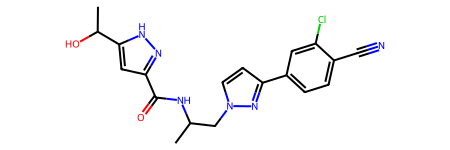

In [346]:
standardize(mol_a)

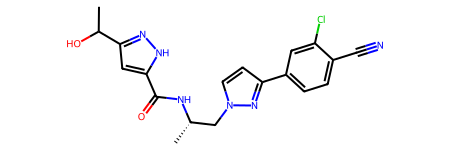

In [347]:
standardize(mol_b)

In [356]:
tuple([1,2])

(1, 2)

In [357]:
query_list = str(drug_diff_df.name.values).replace("[","(").replace("]",")")
sql = f"select pref_name,chembl_id,first_approval from molecule_dictionary where pref_name in {query_list}"
chembl_missing_df = chembl_downloader.query(sql)
merge_df = chembl_missing_df.merge(drug_diff_df,left_on="pref_name",right_on="name")
merge_df

,pref_name,chembl_id,first_approval,sim,smiles,name
0,BENZNIDAZOLE,CHEMBL110,2017,0.214286,O=C(Cn1ccnc1[N+](=O)[O-])NCc1ccccc1,BENZNIDAZOLE


In [270]:
smi_1 = chembl_df.query("chembl_id == 'CHEMBL4297185'").canonical_smiles.values[0]
smi_2 = paper_df.query(q).std_smiles.values[0]

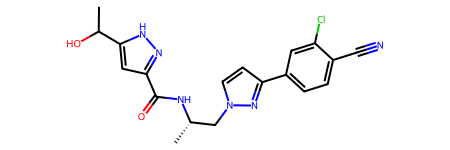

In [277]:
m_1 = Chem.MolFromSmiles(smi_1)
fp_1 = uru.mol2morgan_fp(m_1)
m_1

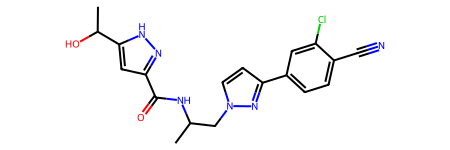

In [278]:
m_2 = Chem.MolFromSmiles(smi_2)
fp_2 = uru.mol2morgan_fp(m_2)
m_2

In [276]:
DataStructs.TanimotoSimilarity(fp_1,fp_2)

1.0

In [250]:
chembl_df = pd.read_csv("chembl_drugs_usan_v2.csv")
chembl_df_2018 = chembl_df.query("first_approval == 2018 and oral == 1").copy()
uru.rd_shut_the_hell_up()
chembl_df_2018['standard_smiles'] = chembl_df_2018.canonical_smiles.apply(get_standard_smiles)
chembl_df_2018['fp'] = chembl_df_2018.standard_smiles.apply(uru.smi2morgan_fp)

ArgumentError: Python argument types in
    rdkit.Chem.MolStandardize.rdMolStandardize.Cleanup(str)
did not match C++ signature:
    Cleanup(RDKit::ROMol const* mol, boost::python::api::object params=None)

In [142]:
sql = "select pref_name,chembl_id,first_approval from molecule_dictionary where pref_name = upper('Sotagliflozin')"
df = chembl_downloader.query(sql)
df

,pref_name,chembl_id,first_approval
0,SOTAGLIFLOZIN,CHEMBL3039507,None


In [140]:
with chembl_downloader.cursor() as cursor:
    query = "select * from molecule_dictionary where pref_name = upper('Sotagliflozin')"
    cursor.execute(query)  
    rows = cursor.fetchall() 
rows

[(1592325,
  'SOTAGLIFLOZIN',
  'CHEMBL3039507',
  4,
  1,
  0,
  'MOL',
  None,
  'Small molecule',
  None,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  2013,
  -1,
  '-gliflozin',
  0,
  '-gliflozin',
  'phlorozin derivatives, phenolic glycosides',
  None,
  0,
  None,
  None,
  None,
  None)]

In [38]:
chembl_df.query("chembl_id == 'CHEMBL17860'")

,canonical_smiles,molregno,pref_name,chembl_id,max_phase,therapeutic_flag,dosed_ingredient,structure_type,chebi_par_id,molecule_type,...,usan_stem,polymer_flag,usan_substem,usan_stem_definition,indication_class,withdrawn_flag,withdrawn_year,withdrawn_country,withdrawn_reason,withdrawn_class
235,CC(Oc1c(Cl)cccc1Cl)C1=NCCN1,20130,LOFEXIDINE,CHEMBL17860,4,1,0,MOL,51368.0,Small molecule,...,NaN,0,NaN,NaN,Antihypertensive,0,NaN,NaN,NaN,NaN


In [39]:
paper_df = pd.read_csv("41570_2022_451_MOESM2_ESM.csv")
paper_df_2018 = paper_df.query("APPROVAL_YEAR == 2018").copy()
paper_df_2018['standard_smiles'] = paper_df_2018.SMILES.apply(get_standard_smiles)
paper_df_2018['fp'] = paper_df_2018.standard_smiles.apply(uru.smi2morgan_fp)

In [43]:
for fp, smiles, name in paper_df_2018[['fp','SMILES','NAME']].values:
    sim_vals = DataStructs.BulkTanimotoSimilarity(fp,chembl_df_2018.fp.values)
    max_sim = max(sim_vals)
    if max_sim < 1.0:
        print(smiles, name, max_sim)

O=C(Cn1ccnc1[N+](=O)[O-])NCc1ccccc1 Benznidazole 0.1686746987951807


In [ ]:
used = set()
for fp, smiles, name in chembl_df_2018[['fp','standard_smiles','pref_name']].values:
    sim_vals = DataStructs.BulkTanimotoSimilarity(fp,paper_df_2018.fp.values)
    max_sim = max(sim_vals)
    if max_sim < 1.0 and smiles not in used:
        used.add(smiles)
        print(smiles, name, max_sim)

In [358]:
!pwd

/Users/pwalters/DATA/DRUGS/2023_01_05
